In [1]:
%pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchinfo import summary
from model import Model_03 as Net

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

# Test Phase transformations
test_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

In [4]:
train = datasets.MNIST("./data", train=True, download=True, transform=train_transforms)
test = datasets.MNIST("./data", train=False, download=True, transform=test_transforms)

In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = (
    dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True)
    if cuda
    else dict(shuffle=True, batch_size=64)
)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


torch.Size([60000, 28, 28])
torch.Size([28, 60000, 28])
[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


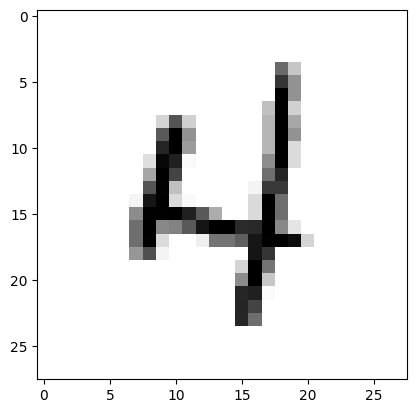

In [6]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.data
train_data = train.transform(train_data.numpy())

print(train.data.shape)
print(train_data.shape)

print('[Train]')
print(' - Numpy Shape:', train.data.cpu().numpy().shape)
print(' - Tensor Shape:', train.data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

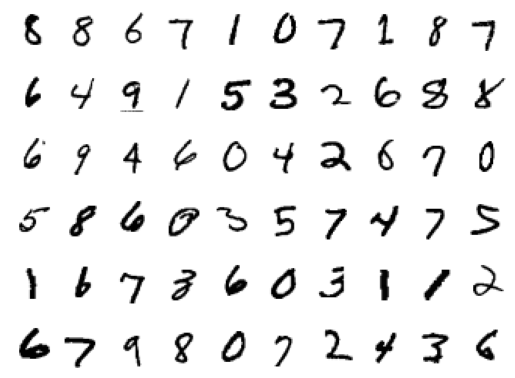

In [7]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis("off")
    plt.imshow(images[index].numpy().squeeze(), cmap="gray_r")

# Receptive Field Calculations for all layers.

n_in | RF_in | k | p | s | J_in | J_out | RF_out | n_out | layer
-----|-------|---|---|---|------|-------|--------|-------|---------
28   |   1   | 3 | 0 | 1 | 1    |   1   |   3    |  26   | conv0_0
26   |   3   | 3 | 0 | 1 | 1    |   1   |   5    |  24   | conv1_0
24   |   5   | 3 | 0 | 1 | 1    |   1   |   7    |  22   | conv1_1
22   |   7   | 2 | 0 | 2 | 1    |   2   |   8    |  11   | trans1_pool0
11   |   8   | 1 | 0 | 1 | 2    |   2   |   8    |  11   | trans1_conv0
11   |   8   | 3 | 0 | 1 | 2    |   2   |   12   |  9    | conv2_0
9    |   12  | 3 | 0 | 1 | 2    |   2   |   16   |  7    | conv2_1
7    |   16  | 1 | 0 | 1 | 2    |   2   |   16   |  7    | conv3_0
7    |   16  | 7 | 0 | 1 | 2    |   2   |   28   |  1    | conv3_1

In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
batch_size = 20
s = summary(
    model,
    input_size=(batch_size, 1, 28, 28),
    verbose=1,
    col_names=[
        "kernel_size",
        "input_size",
        "output_size",
        "num_params",
        "mult_adds",
        "trainable",
    ],
    row_settings=["var_names"],
)

cuda
Layer (type (var_name))                  Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds                 Trainable
Model_03 (Model_03)                      --                        [20, 1, 28, 28]           [20, 10]                  --                        --                        True
├─Sequential (conv0)                     --                        [20, 1, 28, 28]           [20, 10, 26, 26]          --                        --                        True
│    └─Conv2d (0)                        [3, 3]                    [20, 1, 28, 28]           [20, 10, 26, 26]          90                        1,216,800                 True
│    └─ReLU (1)                          --                        [20, 10, 26, 26]          [20, 10, 26, 26]          --                        --                        --
├─Sequential (conv1)                     --                        [20, 10, 26, 26]          [20, 20, 22, 22]   

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

epoch_train_acc = []


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss.item())

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(
            dim=1, keepdim=True
        )  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(
            desc=f"Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}"
        )
        train_acc.append(100 * correct / processed)

    # epoch accuracy = accuracy for the whole batch
    epoch_train_acc.append(100 * correct / processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print(
        "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

    test_acc.append(100.0 * correct / len(test_loader.dataset))

In [10]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=2.3026037216186523 Batch_id=468 Accuracy=16.40: 100%|██████████| 469/469 [00:07<00:00, 58.94it/s]


Test set: Average loss: 2.3026, Accuracy: 1264/10000 (12.64%)

EPOCH: 1


Loss=2.302327871322632 Batch_id=468 Accuracy=15.01: 100%|██████████| 469/469 [00:07<00:00, 60.16it/s] 


Test set: Average loss: 2.3023, Accuracy: 1838/10000 (18.38%)

EPOCH: 2


Loss=0.38447046279907227 Batch_id=468 Accuracy=54.02: 100%|██████████| 469/469 [00:07<00:00, 61.18it/s]


Test set: Average loss: 0.2301, Accuracy: 9301/10000 (93.01%)

EPOCH: 3


Loss=0.10176997631788254 Batch_id=468 Accuracy=93.90: 100%|██████████| 469/469 [00:08<00:00, 57.15it/s] 


Test set: Average loss: 0.1310, Accuracy: 9600/10000 (96.00%)

EPOCH: 4


Loss=0.2907315492630005 Batch_id=468 Accuracy=96.06: 100%|██████████| 469/469 [00:08<00:00, 57.34it/s]  


Test set: Average loss: 0.1040, Accuracy: 9687/10000 (96.87%)

EPOCH: 5


Loss=0.034378789365291595 Batch_id=468 Accuracy=96.93: 100%|██████████| 469/469 [00:08<00:00, 55.68it/s]


Test set: Average loss: 0.0853, Accuracy: 9737/10000 (97.37%)

EPOCH: 6


Loss=0.019944164901971817 Batch_id=468 Accuracy=97.31: 100%|██████████| 469/469 [00:07<00:00, 65.10it/s]


Test set: Average loss: 0.0784, Accuracy: 9754/10000 (97.54%)

EPOCH: 7


Loss=0.024451427161693573 Batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:06<00:00, 67.25it/s]


Test set: Average loss: 0.0658, Accuracy: 9797/10000 (97.97%)

EPOCH: 8


Loss=0.04024827107787132 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:07<00:00, 62.77it/s] 


Test set: Average loss: 0.0598, Accuracy: 9805/10000 (98.05%)

EPOCH: 9


Loss=0.05707074701786041 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:07<00:00, 64.82it/s] 


Test set: Average loss: 0.0620, Accuracy: 9806/10000 (98.06%)

EPOCH: 10


Loss=0.06526177376508713 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:07<00:00, 64.23it/s] 


Test set: Average loss: 0.0676, Accuracy: 9777/10000 (97.77%)

EPOCH: 11


Loss=0.058218833059072495 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:07<00:00, 62.02it/s] 


Test set: Average loss: 0.0600, Accuracy: 9813/10000 (98.13%)

EPOCH: 12


Loss=0.04993945732712746 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:07<00:00, 62.84it/s]  


Test set: Average loss: 0.0554, Accuracy: 9818/10000 (98.18%)

EPOCH: 13


Loss=0.025709522888064384 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:07<00:00, 63.74it/s] 


Test set: Average loss: 0.0602, Accuracy: 9820/10000 (98.20%)

EPOCH: 14


Loss=0.015203804709017277 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:07<00:00, 61.78it/s] 


Test set: Average loss: 0.0451, Accuracy: 9839/10000 (98.39%)



Text(0.5, 1.0, 'Test Accuracy')

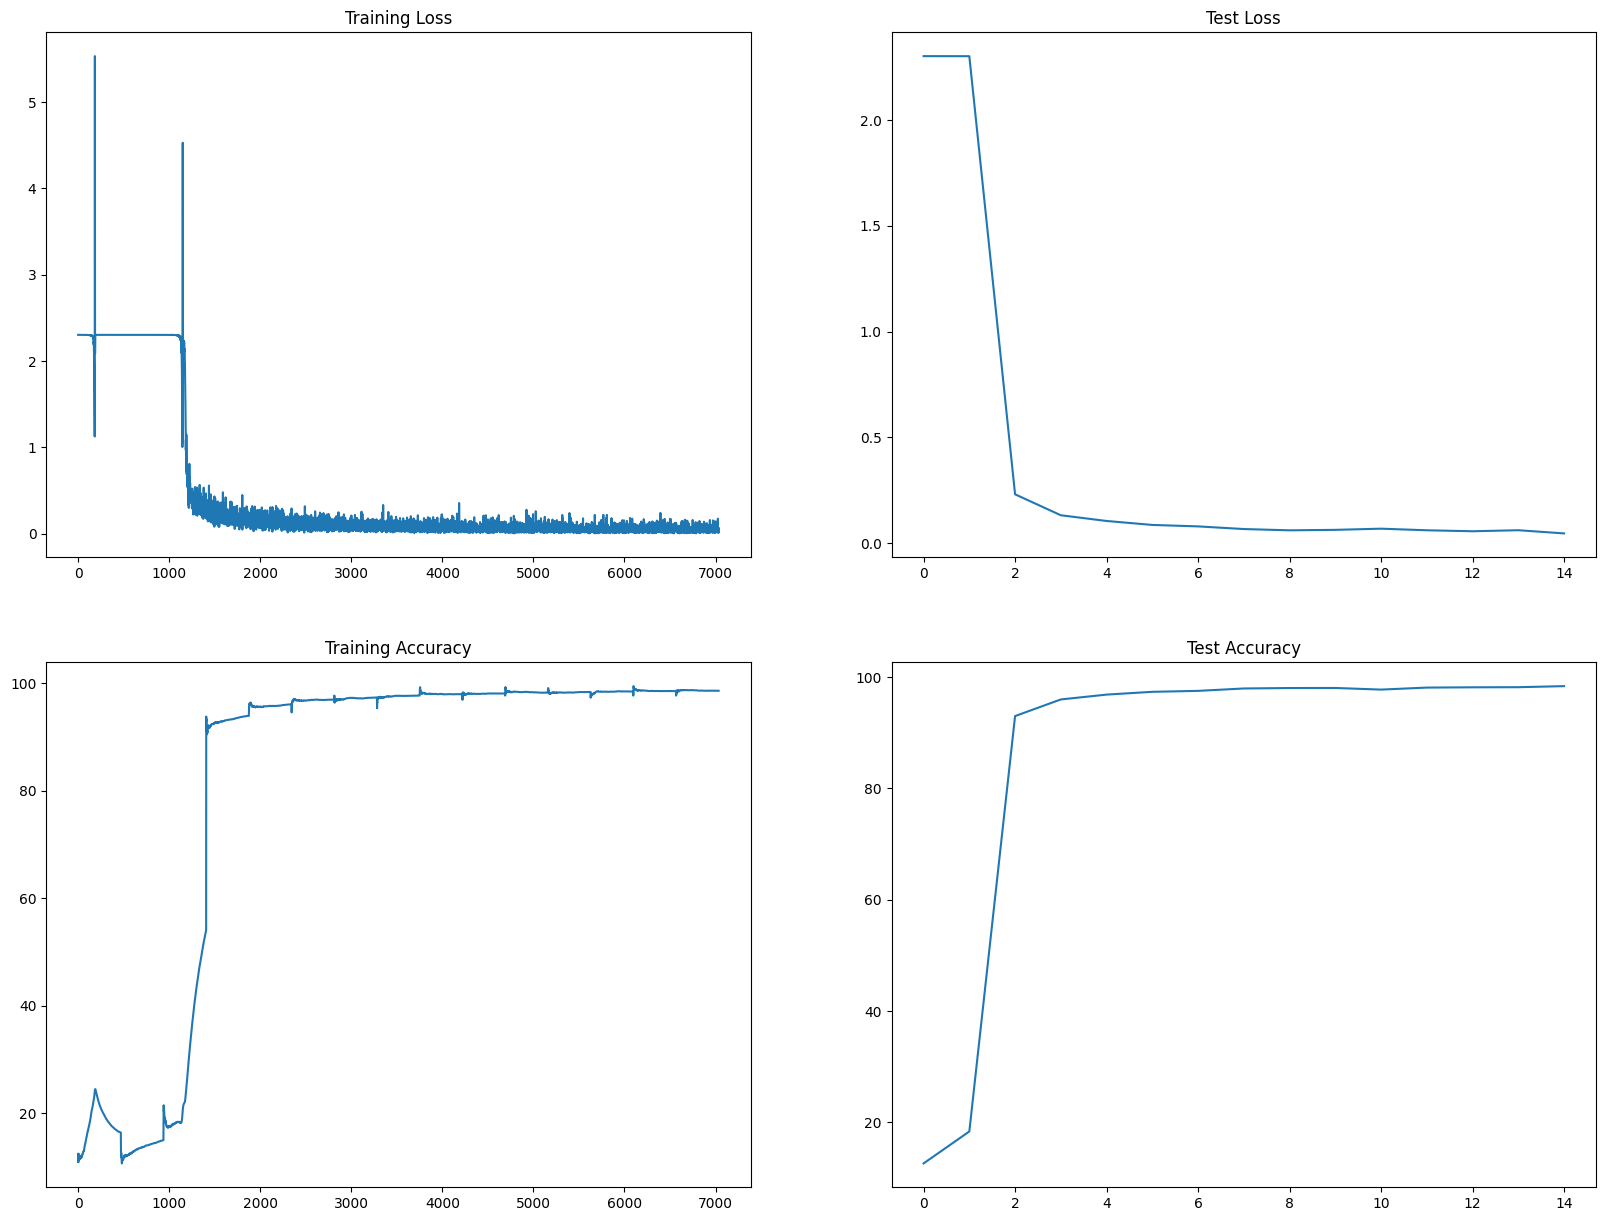

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [12]:
print("Minimum training loss = {:.9f}%".format(min(train_losses)))
print("Minimum testing loss = {:.9f}%".format(min(test_losses)))
print("Best training accuracy = {:.2f}%".format(max(epoch_train_acc)))
print("Best testing accuracy = {:.2f}%".format(max(test_acc)))

Minimum training loss = 0.001984583%
Minimum testing loss = 0.045149617%
Best training accuracy = 98.56%
Best testing accuracy = 98.39%



# Target:

1.  To make the model lighter i.e. less number of parameters

# Results:

*   Parameters = 10,790
*   Best training accuracy = 98.56%
*   Best testing accuracy = 98.39%

# Analysis:

*   Model is still larger than our target, but it's still a good model
*   Model is not over-fitting as evident by the delta in training and testing accuracy. If training accuracy is improved, I can see the model achieving the target testing accuracy